# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', 500) # To display all the columns of dataframe
pd.set_option('max_colwidth', None) # To set the width of the column to maximum

# Load Data

In [ ]:
link = "https://drive.google.com/file/d/1cRNvH7NAdSxIDA5g5uKjtXMEJZ08F1NX/view"
path = "https://drive.google.com/uc?id=" + link.split("/")[-2]
df = pd.read_csv(path)

# Verify shapes
print("Data Shape:", df.shape)

Data Shape: (2000, 8)


# Data Preview and Info

In [ ]:
# Display few rows of dataset
print("Data Preview:")
display(df.head())

Data Preview:


,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [ ]:
MAP_VALUE = {
    "Sex": {0: "male", 1: "female"},
    "Marital status": {0: "single", 1: "non-single"},
    "Education": {0: "other", 1: "high school", 2: "university", 3: "graduate school"},
    "Occupation": {0: "unemployed", 1: "skilled employee", 2: "management"},
    "Settlement size": {0: "small city", 1: "mid-sized city", 2: "big city"},
}
for feature, map_val in MAP_VALUE.item():
  df[feature] = df[feature].map(map_val)

# df["Sex"] = df["Sex"].map({0: "male", 1: "female"})
# df["Marital status"] = df["Marital status"].map({0: "single", 1: "non-single"})
# df["Education"] = df["Education"].map({0: "other", 1: "high school", 2: "university", 3: "graduate school"})
# df["Occupation"] = df["Occupation"].map({0: "unemployed", 1: "skilled employee", 2: "management"})
# df["Settlement size"] = df["Settlement size"].map({0: "small city", 1: "mid-sized city", 2: "big city"})

In [ ]:
df.columns = (
    df.columns
    .str.strip()
)

# Display information about the DataFrames
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               2000 non-null   int64 
 1   Sex              2000 non-null   object
 2   Marital status   2000 non-null   object
 3   Age              2000 non-null   int64 
 4   Education        2000 non-null   object
 5   Income           2000 non-null   int64 
 6   Occupation       2000 non-null   object
 7   Settlement size  2000 non-null   object
dtypes: int64(3), object(5)
memory usage: 125.1+ KB


In [ ]:
df["Settlement size"].value_counts()

,count
Settlement size,
small city,989
mid-sized city,544
big city,467


## Insights from Initial Data Exploration

**Dataset Size and Structure**  
   - The **dataset** contains **2000** samples with **8** columns.
**Feature Overview**  
   - The datasets include all important attributes:
     - **Numerical features:** `Age`, `Income`.
     - **Categorical features:** `Sex`, `Marital status`, `Education`, `Occupation`, `Settlement size`.

**Data Completeness**  
   - The dataset have **no missing values**.
   - Data types are appropriate: numerical features are int64 and categorical features is object
   - We need to drop column ID.

In [ ]:
df.drop(columns="ID", axis=1, inplace=True)
num_features = ["Age", "Income"]
cat_features = ["Sex", "Marital status", "Education", "Occupation", "Settlement size"]
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df[num_features].describe().T.style.background_gradient(cmap=cm))

Data describe:


,count,mean,std,min,25%,50%,75%,max
Age,2000.000000,35.909000,11.719402,18.000000,27.000000,33.000000,42.000000,76.000000
Income,2000.000000,120954.419000,38108.824679,35832.000000,97663.250000,115548.500000,138072.250000,309364.000000


## Descriptive Insights – Numerical Features

* **Age**: min = 18, max = 76, mean = 35.9 years.

  * Most customers are between **27 and 42 years old** (the interquartile range).

* **Income**: min = 35,832, max = 309,364, mean ≈ 120,954.

  * Most customers earn between **97,663 and 138,072** (the interquartile range).

Overall, the dataset represents mainly **young to middle-aged adults** with **moderate to high income levels**.


In [ ]:
def convert_cat(features, df = df):
    for feature in features:
        if feature in df.columns:
            df[feature] = df[feature].astype("category")
convert_cat(cat_features)

# Display information about the DataFrames
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Sex              2000 non-null   category
 1   Marital status   2000 non-null   category
 2   Age              2000 non-null   int64   
 3   Education        2000 non-null   category
 4   Income           2000 non-null   int64   
 5   Occupation       2000 non-null   category
 6   Settlement size  2000 non-null   category
dtypes: category(5), int64(2)
memory usage: 41.8 KB


In [ ]:
print("Data describe:")
cat_summary = df[cate_features].describe().T
cat_summary.style.background_gradient(cmap="Blues", subset=["unique", "freq"])

Data describe:


,count,unique,top,freq
Sex,2000,2,male,1086
Marital status,2000,2,single,1007
Education,2000,4,high school,1386
Occupation,2000,3,skilled employee,1113
Settlement size,2000,3,small city,989


## Categorical Feature Insights

* **Sex**: 2 categories → Male (1,086), Female (914).

  * The majority are **male** customers.

* **Marital status**: 2 categories → Single (1,007), Married (993).

  * The distribution is almost balanced, but slightly more are **single**.

* **Education**: 4 categories → High school (1,386), others (614).

  * The majority are **high school educated** customers.

* **Occupation**: 3 categories → Skilled employee (1,113), others (887).

  * The majority are **skilled employees**.

* **Settlement size**: 3 categories → Small city (989), others (1,011).

  * The distribution is quite balanced, but the largest single group is **small city** residents.


# Data Quality Checks

## Missing Value

In [ ]:
def displayNULL(df, dataset_name=None):
    total_rows = len(df)

    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ["Feature", "Missing_Count"]
    missing_df = missing_df[missing_df["Missing_Count"] > 0]
    missing_df["Missing_%"] = (missing_df["Missing_Count"] / total_rows * 100).round(2)
    missing_df = missing_df.sort_values(by="Missing_Count", ascending=False).reset_index(drop=True)

    total_missing = missing_df["Missing_Count"].sum()

    print("=" * 40)
    if dataset_name:
        print(f"🔎 Missing Value Summary for: {dataset_name}")
    else:
        print("🔎 Missing Value Summary:")
    print("=" * 40)

    if total_missing == 0:
        print(f"✅ No missing values detected in {total_rows:,} rows.")
    else:
        try:
            from tabulate import tabulate
            print(tabulate(missing_df, headers="keys", tablefmt="pretty", showindex=False, colalign=("left", "left", "left")))
        except ImportError:
            print(missing_df.to_string(index=False))

        print(f"\n⚠️  Total missing values: {total_missing:,} out of {total_rows:,} rows.")

print("Missing value dataset: ")
displayNULL(df, dataset_name="Dataset")

Missing value dataset: 
🔎 Missing Value Summary for: Dataset
✅ No missing values detected in 2,000 rows.


## Checking duplicate Value

In [ ]:
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)

    print("=" * 40)
    print(f"🔍 {dataset_name} Duplicate Analysis")
    print("=" * 40)

    if duplicates_count == 0:
        print(f"✅ No duplicates found in {total_rows:,} rows")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Data": df
}

duplicate_summary = {}
for name, data in datasets.items():
    check_duplicates_report(data, name)
    duplicate_summary[name] = {
        "duplicates": data.duplicated().sum(),
        "total_rows": len(data)
    }

🔍 Data Duplicate Analysis
✅ No duplicates found in 2,000 rows


## Checking Outlier Value

In [ ]:
def checking_outlier(list_feature, df, dataset_name):
    print("=" * 40)
    print(f"🔍 {dataset_name} Checking outlier")
    print("=" * 40)
    outlier_info = []

    for feature in list_feature:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]

        if len(outliers) > 0:
            outlier_info.append({
                "Feature": feature,
                "Outlier Count": len(outliers),
                # "Outlier Detail": outliers.tolist()
            })

    if len(outlier_info) == 0:
        print("✅ No outliers detected in the selected features.")
    else:
        return pd.DataFrame(outlier_info)

checking_outlier(list_feature=num_features, df=df, dataset_name="Data")

🔍 Data Checking outlier


,Feature,Outlier Count
0,Age,57
1,Income,83


## Data Quality Insights: Missing Values, Duplicates and Outliers.

**Missing Values Analysis**

* We conducted a thorough examination for missing values in the dataset.

* **No missing values** were detected — ensuring clean synthetic data for model training.

**Duplicate Records Analysis**

* We performed a check for exact duplicate rows that could artificially inflate performance or introduce bias.

  * **No duplicates** detected in 2000 rows — ensuring test predictions are made on unique samples.

**Outlier Analysis**

* We also examined the datasets for checking outliers.
* **The outliers** were found in dataset at features. But we can not remove them since these outliers reflect reality.

**Conclusion**

* The dataset demonstrates **excellent data quality** with **no missing values** and **no duplicate records**, ensuring reliable inputs for analysis and modeling.
* **Outliers are present** in features such as `Age` and `Income`, but they represent realistic variations in financial transactions and should not be removed outright.
* Overall, the dataset is **well-prepared for modeling**, requiring only standard preprocessing steps (e.g., encoding categorical variables, scaling numerical features, and handling outliers carefully if needed).

# Data PreProcessing

## SCALE DATA and ENCODE

In [ ]:
num_stand_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median"))
])

cat_onehot_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")) # Handling Text and Categorical Attributes
])

preprocessor = ColumnTransformer(transformers=[
    ("num_stand", num_stand_transformer, num_features),
    ("cat_keep", cat_onehot_transformer, cat_features),
])

X_scale = preprocessor.fit_transform(df)

In [ ]:
list_feature_prepared = preprocessor.get_feature_names_out().tolist()
list_feature_prepared

['num_stand__Age',
 'num_stand__Income',
 'cat_keep__Sex_female',
 'cat_keep__Sex_male',
 'cat_keep__Marital status_non-single',
 'cat_keep__Marital status_single',
 'cat_keep__Education_graduate school',
 'cat_keep__Education_high school',
 'cat_keep__Education_other',
 'cat_keep__Education_university',
 'cat_keep__Occupation_management',
 'cat_keep__Occupation_skilled employee',
 'cat_keep__Occupation_unemployed',
 'cat_keep__Settlement size_big city',
 'cat_keep__Settlement size_mid-sized city',
 'cat_keep__Settlement size_small city']

# Modeling

In [ ]:
!pip install kneed

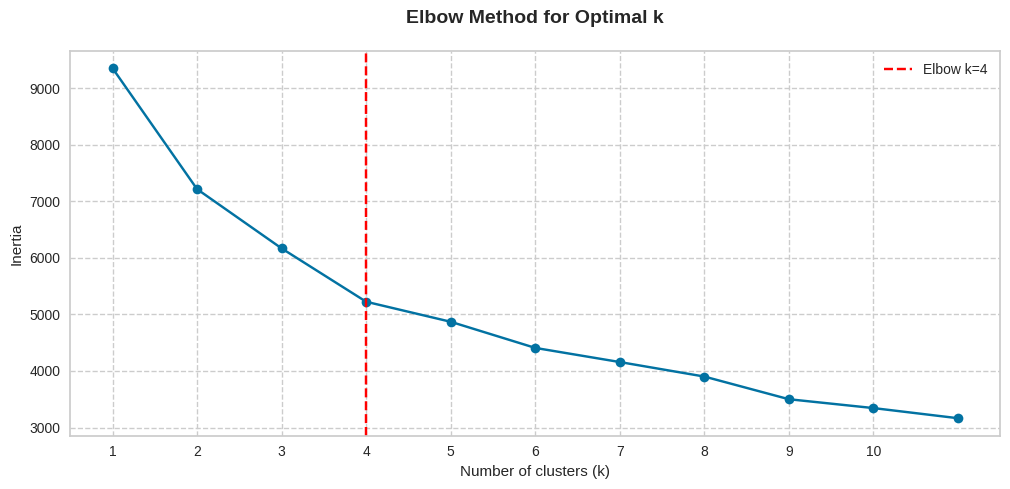

Optimal k suggested by Elbow: 4


In [ ]:
from sklearn.cluster import KMeans

from kneed import KneeLocator # Refer on Kaggle

# --- Elbow Method ---
inertia = []
K_elbow = range(1, 12)  # k = 1..12
for k in K_elbow:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scale)
    inertia.append(kmeans.inertia_)

# Find the elbow point
kneedle = KneeLocator(list(K_elbow), inertia, curve="convex", direction="decreasing")
k_best_elbow = kneedle.knee

# Plot Elbow
plt.figure(figsize=(12, 5))
plt.plot(list(K_elbow), inertia, marker="o", linestyle="-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k", fontsize=14, pad=20, weight="bold")
plt.grid(True, linestyle="--")
plt.xticks(range(1, 11))

# Mark elbow if found
if k_best_elbow is not None:
    plt.axvline(k_best_elbow, linestyle="--", label=f"Elbow k={k_best_elbow}", color="red")
    plt.legend()

plt.show()

print(f"Optimal k suggested by Elbow: {k_best_elbow}")

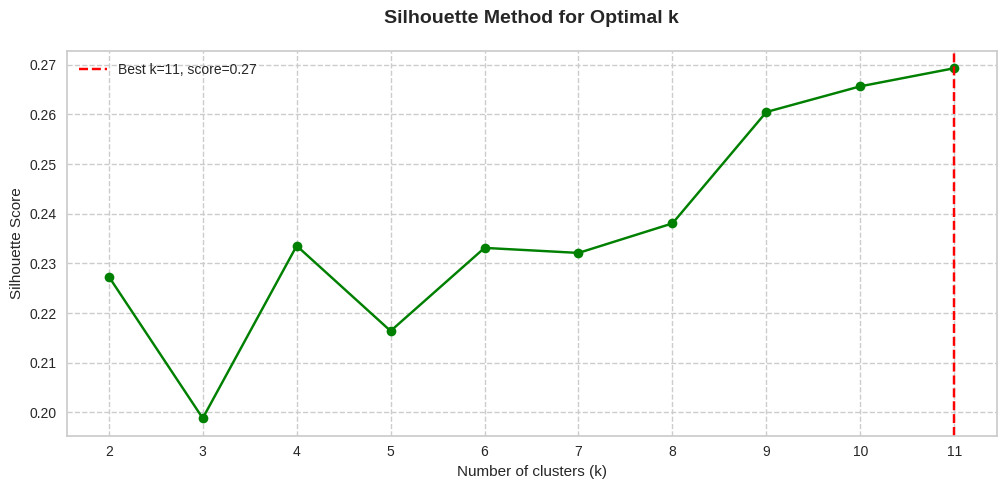

Optimal k suggested by Silhouette: 11


In [ ]:
from sklearn.metrics import silhouette_score
# --- Silhouette Method ---
silhouette_scores = []
K_silhouette = range(2, 12)  # silhouette score không dùng được với k=1

for k in K_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scale)
    score = silhouette_score(X_scale, labels)
    silhouette_scores.append(score)

# Tìm k có silhouette score cao nhất
best_k_silhouette = K_silhouette[silhouette_scores.index(max(silhouette_scores))]

# Plot Silhouette
plt.figure(figsize=(12, 5))
plt.plot(list(K_silhouette), silhouette_scores, marker="o", linestyle="-", color="green")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k", fontsize=14, pad=20, weight="bold")
plt.grid(True, linestyle="--")
plt.xticks(range(2, 12))

# Mark best silhouette score
plt.axvline(best_k_silhouette, linestyle="--", color="red",
            label=f"Best k={best_k_silhouette}, score={max(silhouette_scores):.2f}")
plt.legend()

plt.show()

print(f"Optimal k suggested by Silhouette: {best_k_silhouette}")


In [ ]:
# We choice k = 4
model = KMeans(n_clusters=4, random_state=42)
df["name_cluster"] = model.fit_predict(X_scale)
df

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,name_cluster
0,male,single,67,university,124670,skilled employee,big city,3
1,female,non-single,22,high school,150773,skilled employee,big city,1
2,male,single,49,high school,89210,unemployed,small city,2
3,male,single,45,high school,171565,skilled employee,mid-sized city,0
4,male,single,53,high school,149031,skilled employee,mid-sized city,0
...,...,...,...,...,...,...,...,...
1995,female,single,47,high school,123525,unemployed,small city,2
1996,female,non-single,27,high school,117744,skilled employee,small city,1
1997,male,single,31,other,86400,unemployed,small city,2
1998,female,non-single,24,high school,97968,unemployed,small city,2


# EDA

In [ ]:
def color(n_colors=2):
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
    positions = np.linspace(0, 1, n_colors)
    colors = [cmap(p) for p in positions]
    return colors

## name_cluster

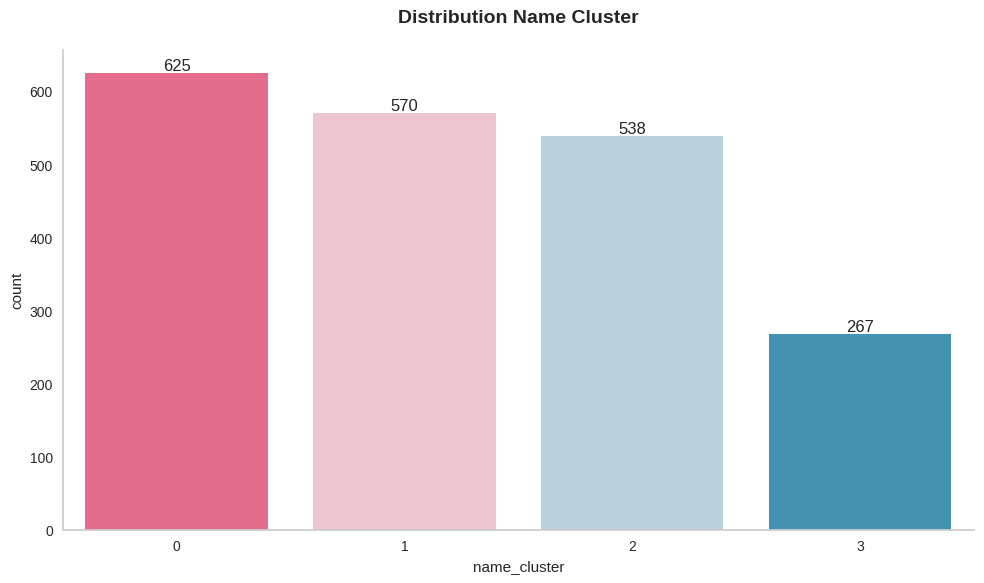

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="name_cluster", data = df, palette = color(n_colors=4), hue = "name_cluster");
sns.despine()
for val in ax.containers:
  ax.bar_label(val)
plt.title("Distribution Name Cluster", weight="bold", pad=20, fontsize=14)
plt.legend().remove()
plt.tight_layout()
plt.grid(False)
plt.show()

## Sex

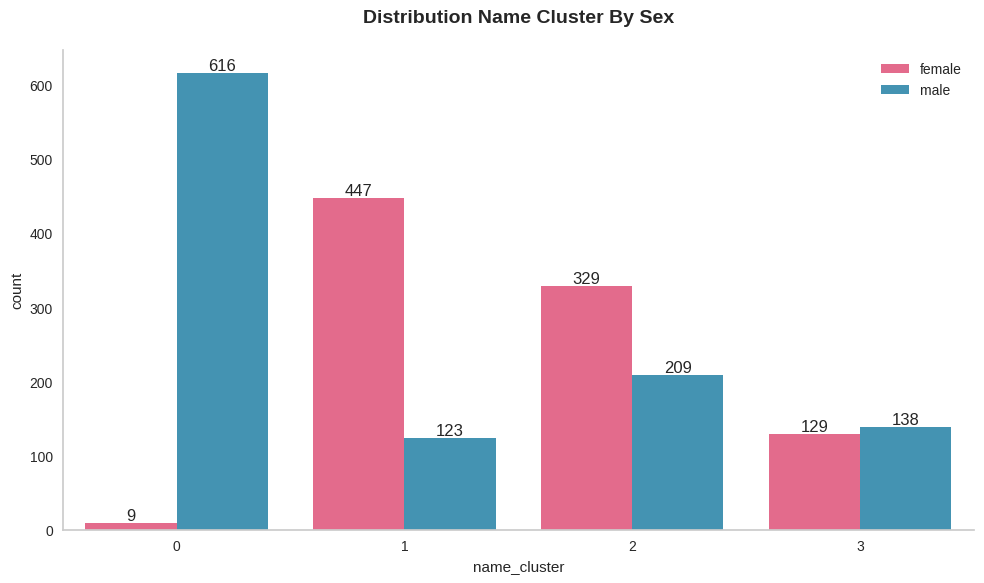

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="name_cluster", data = df, palette = color(n_colors=2), hue = "Sex");
sns.despine()
for val in ax.containers:
  ax.bar_label(val)
plt.title("Distribution Name Cluster By Sex", weight="bold", pad=20, fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

## Marital status

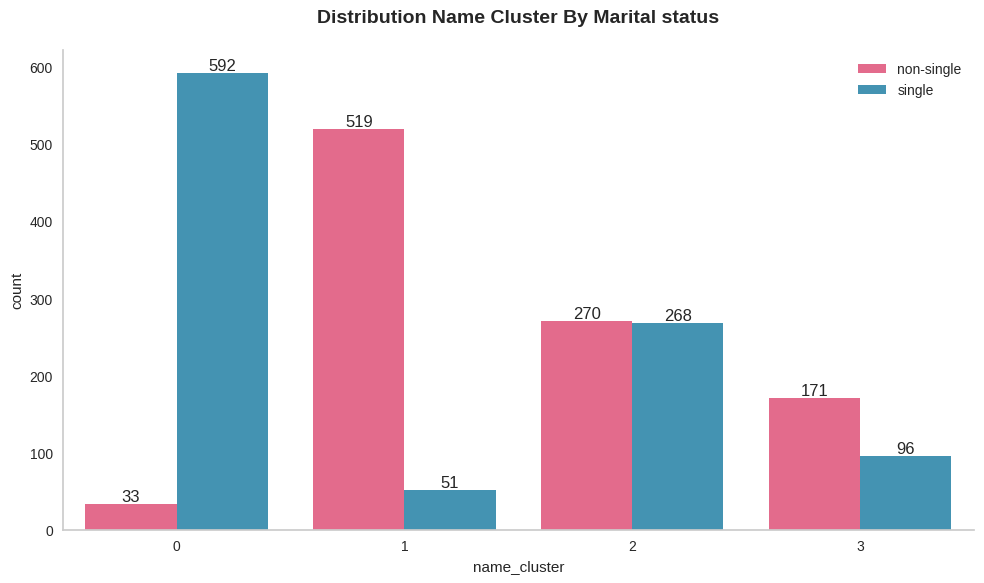

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="name_cluster", data = df, palette = color(n_colors=2), hue = "Marital status");
sns.despine()
for val in ax.containers:
  ax.bar_label(val)
plt.title("Distribution Name Cluster By Marital status", weight="bold", pad=20, fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

## Age

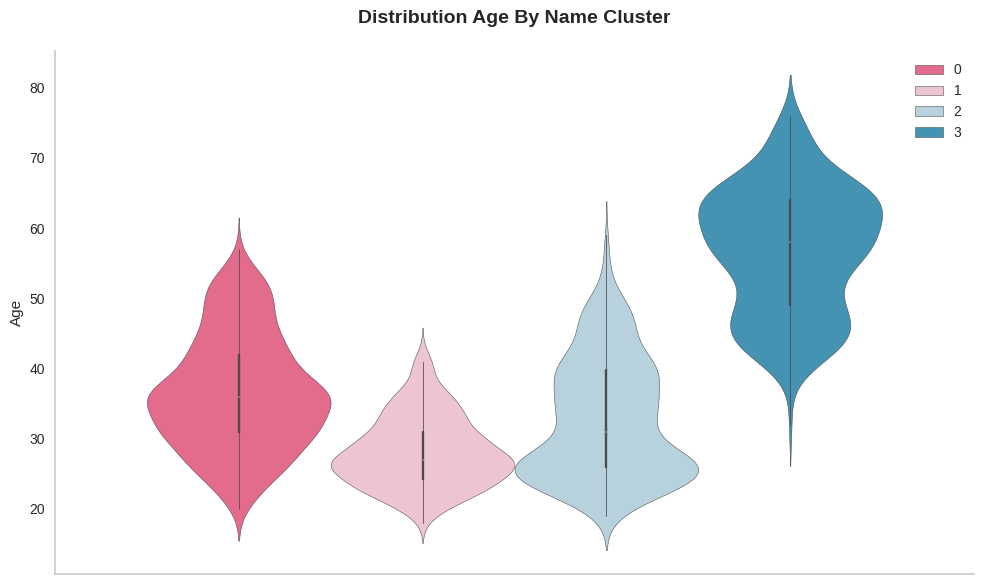

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(y="Age", data = df, palette = color(n_colors=4), hue = "name_cluster");
sns.despine()
plt.title("Distribution Age By Name Cluster", weight="bold", pad=20, fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

## Education

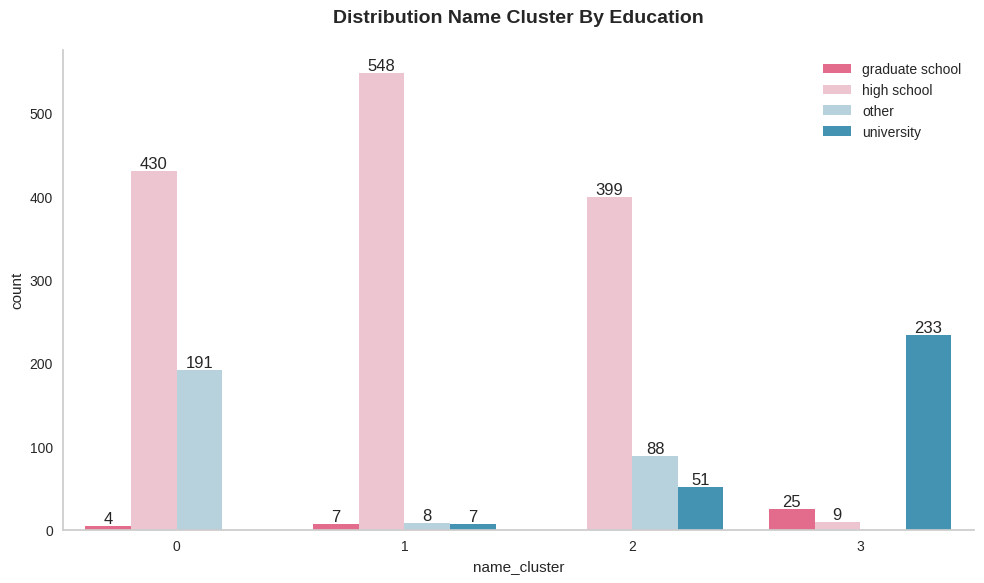

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="name_cluster", data = df, palette = color(n_colors=4), hue = "Education");
sns.despine()
for val in ax.containers:
  ax.bar_label(val)
plt.title("Distribution Name Cluster By Education", weight="bold", pad=20, fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

In [ ]:
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,name_cluster
0,male,single,67,university,124670,skilled employee,big city,3
1,female,non-single,22,high school,150773,skilled employee,big city,1
2,male,single,49,high school,89210,unemployed,small city,2
3,male,single,45,high school,171565,skilled employee,mid-sized city,0
4,male,single,53,high school,149031,skilled employee,mid-sized city,0


## Income

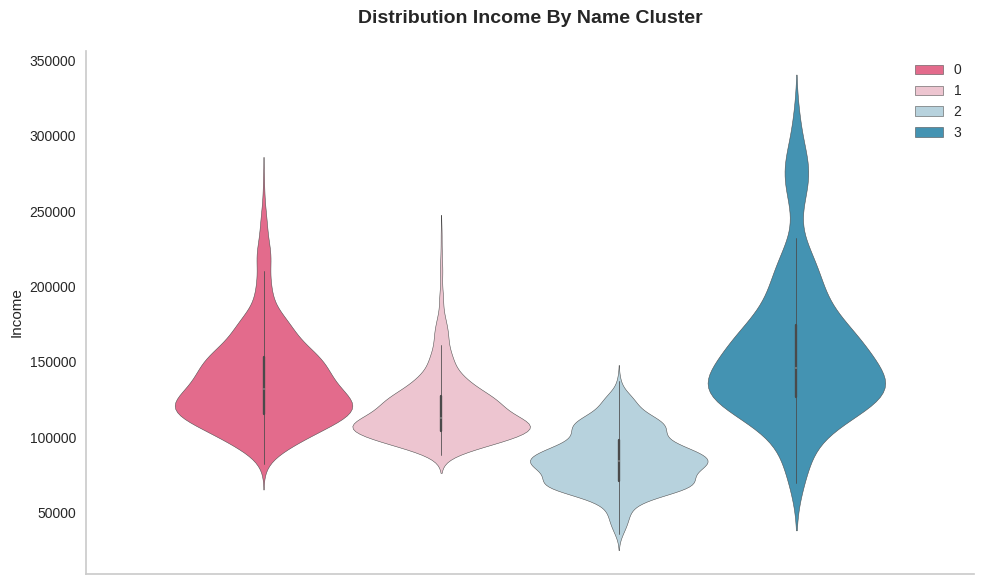

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(y="Income", data = df, palette = color(n_colors=4), hue = "name_cluster");
sns.despine()
plt.title("Distribution Income By Name Cluster", weight="bold", pad=20, fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

## Occupation

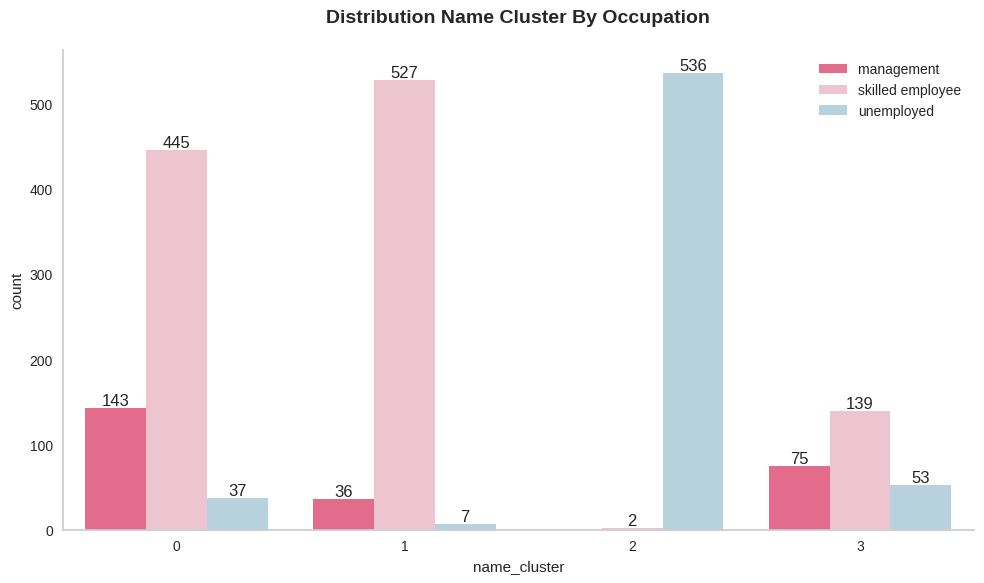

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="name_cluster", data = df, palette = color(n_colors=4), hue = "Occupation");
sns.despine()
for val in ax.containers:
  ax.bar_label(val)
plt.title("Distribution Name Cluster By Occupation", weight="bold", pad=20, fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

## Settlement size

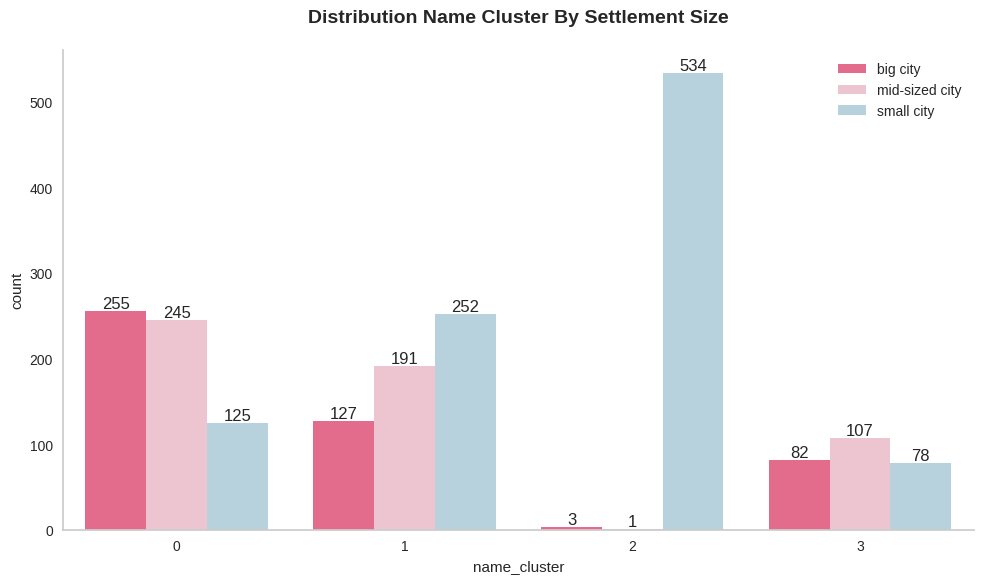

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="name_cluster", data = df, palette = color(n_colors=4), hue = "Settlement size");
sns.despine()
for val in ax.containers:
  ax.bar_label(val)
plt.title("Distribution Name Cluster By Settlement Size", weight="bold", pad=20, fontsize=14)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

**Cluster 0 (625 members)**

* **Sex**: Predominantly **male** (616 vs 9 female).
* **Marital Status**: Mostly **single** (592 vs 33 non-single).
* **Age**: Around **30–40 years old**, median ≈ mid-30s.
* **Education**: Majority with **high school education**, followed by some **other** category.
* **Occupation**: Mostly **skilled employees**, with a fair share in **management**.
* **Settlement size**: Spread across big cities and mid-sized cities, fewer from small cities.
* **Income**: Mid-to-high income (median \~120K).

**Profile**: Younger **single males**, mostly **skilled employees** with **high school education**, living in bigger cities, earning **moderately high incomes**.

**Cluster 1 (570 members)**

* **Sex**: More **female** (447) than male (123).
* **Marital Status**: Mostly **non-single** (519 vs 51).
* **Age**: Younger group, median \~27–30 years.
* **Education**: Dominated by **high school graduates**.
* **Occupation**: Vast majority are **skilled employees**.
* **Settlement size**: More from **mid-sized and small cities**.
* **Income**: Lower than Cluster 0, around **100K–120K** median.

**Profile**: **Young women**, mostly **non-single**, with **high school education**, employed as **skilled workers** in **smaller or mid-sized cities**, earning **lower-middle incomes**.

**Cluster 2 (538 members)**

* **Sex**: Slightly more **female** (329 vs 209 male).
* **Marital Status**: Evenly split between single and non-single.
* **Age**: Relatively young, median early 30s.
* **Education**: Mix of **high school** and **other education**, fewer university/graduate.
* **Occupation**: Strongly dominated by the **unemployed group** (536).
* **Settlement size**: Concentrated in **small cities**.
* **Income**: Lowest among clusters (median \~90K–100K).

**Profile**: **Younger unemployed individuals**, mostly from **small cities**, with **lower income levels** and **basic education**.

**Cluster 3 (267 members)**

* **Sex**: Balanced male (138) and female (129).
* **Marital Status**: More **non-single** (171 vs 96).
* **Age**: Older group, median \~55–60 years, up to 76.
* **Education**: Higher representation of **university graduates**.
* **Occupation**: Mix of **skilled employees**, **management**, and some unemployed.
* **Settlement size**: Distributed across all city sizes fairly evenly.
* **Income**: Highest among all clusters, median \~150K+, with outliers reaching \~300K.

**Profile**: **Older, well-educated individuals** (often university), with **higher income**, more stable in **marital status**, and spread across different settlement sizes.


**Overall Summary Table**

| Cluster | Size | Sex           | Marital           | Age     | Education         | Occupation           | Settlement       | Income             |
| ------- | ---- | ------------- | ----------------- | ------- | ----------------- | -------------------- | ---------------- | ------------------ |
| **0**   | 625  | Mostly male   | Mostly single     | 30–40   | High school       | Skilled employees    | Big/mid cities   | Mid-high (\~120K)  |
| **1**   | 570  | Mostly female | Mostly non-single | \~27–30 | High school       | Skilled employees    | Mid/small cities | Lower (\~100–120K) |
| **2**   | 538  | More female   | Balanced          | \~30–35 | High school/Other | Mostly unemployed    | Small cities     | Lowest (\~90–100K) |
| **3**   | 267  | Balanced      | More non-single   | \~55–60 | More university   | Mixed (mgmt/skilled) | All sizes        | Highest (\~150K+)  |